In [40]:
#in this workbook, I will take the model generated and apply it against the November data set as the basis of the Kaggle submission

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
Nov=pd.read_csv("/home/cdsw/Novdata_for_preds.csv")

In [42]:
# Load from file
with open("/home/cdsw/Models/rf_red_1000_min5_v2", 'rb') as file:
    rf2 = pickle.load(file)

In [43]:
#reduce the data down to those which are non null
Nov2=Nov[Nov.PStdMinus1.notnull()]
#extract the target variable
Nov3=Nov2.drop(["Target"],axis="columns")
Nov3=Nov3.drop(Nov3.iloc[:,0:24],axis=1)
#predict the results from the remaining data
preds1=pd.Series(rf2.predict(Nov3))

In [44]:
round(yhat2,0).astype("int64").describe()

count    61387.000000
mean         0.759933
std          5.216102
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        453.000000
dtype: float64

In [66]:
# read in the second Nov data and mod 2
# NovData2=pd.read_csv("/home/cdsw/Novdata_for_mod2_v1.csv")
NovData2=pd.read_csv("/home/cdsw/Novdata_for_mod2_v2.csv")
with open("/home/cdsw/Models/mod2_rf_1000_min5_v2", 'rb') as file:
    mod2 = pickle.load(file)

In [71]:
NovData2_2=NovData2.drop(["Target"],axis="columns")
NovData2_2["AV3Months"]=NovData2_2.loc[: , "Shop_min3":"Shop_min1"].mean(axis=1)
NovData2_2.drop(NovData2_2.columns.to_series().loc["Unnamed: 0":"shop_id"],axis=1,inplace=True)

#predict the results from the remaining data
preds2=pd.Series(mod2.predict(NovData2_2))


In [72]:
round(preds2,0).astype("int64").describe()

count    1.002934e+06
mean     3.596388e-01
std      6.396752e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.800000e+01
dtype: float64

In [74]:
#read in the submission format to know what I have to prepare
submission=pd.read_csv("/home/cdsw/01_future-sales/data/test.csv")
#Need to append to orig data sets
prep=Nov2.loc[:,["shop_id","item_id"]]
prep.reset_index(drop=True,inplace=True)
prep["Sales_preds1"]=preds1

prep2=NovData2.loc[:,["shop_id","item_id"]]
prep2.reset_index(drop=True,inplace=True)
prep2["Sales_preds2"]=preds2

sub=pd.merge(submission, prep, how="left",on=["shop_id","item_id"])
sub2=pd.merge(sub, prep2, how="left", on=["shop_id","item_id"])
sub2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 5 columns):
ID              214200 non-null int64
shop_id         214200 non-null int64
item_id         214200 non-null int64
Sales_preds1    47696 non-null float64
Sales_preds2    198954 non-null float64
dtypes: float64(2), int64(3)
memory usage: 9.8 MB


In [75]:
print("Number where can make a submission:" ,len(sub2)-len(sub2[(sub2.Sales_preds1.isnull())& (sub2.Sales_preds2.isnull())]))

Number where can make a submission: 198954


In [76]:
sub2.head()

,ID,shop_id,item_id,Sales_preds1,Sales_preds2
0,0,5,5037,NaN,1.779551
1,1,5,5320,NaN,NaN
2,2,5,5233,0.634556,1.631441
3,3,5,5232,NaN,1.002701
4,4,5,5268,NaN,NaN


In [77]:
#submission where take preds2 if there is a conflict
sub2["endresult"]=np.where(sub2.Sales_preds2.isnull(),sub2.Sales_preds1,sub2.Sales_preds2)
sub2["item_cnt_month"]=sub2.endresult.fillna(0)
sub3=sub2.drop(["Sales_preds1","Sales_preds2","endresult","shop_id","item_id"],axis=1)
sub3.to_csv("/home/cdsw/Submission2_Predict117k_mod2pref_2.csv",index=False)
sub3.head()

,ID,item_cnt_month
0,0,1.779551
1,1,0.000000
2,2,1.631441
3,3,1.002701
4,4,0.000000


In [78]:
#create a version where preds1 has dominance
sub4=sub2.drop(["item_cnt_month"], axis="columns")
sub4["endresult2"]=np.where(sub2.Sales_preds1.notnull(),sub2.Sales_preds1,sub2.Sales_preds2)
sub4["item_cnt_month"]=sub4.endresult2.fillna(0)
sub5=sub4.drop(["Sales_preds1","Sales_preds2","endresult", "endresult2","shop_id","item_id"],axis=1)
sub5.to_csv("/home/cdsw/Submission2_Predict117k_mod1pref_2.csv",index=False)
sub5.head()

,ID,item_cnt_month
0,0,1.779551
1,1,0.000000
2,2,0.634556
3,3,1.002701
4,4,0.000000


In [48]:
eg=pd.read_csv("/home/cdsw/01_future-sales/data/sample_submission.csv")
eg.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


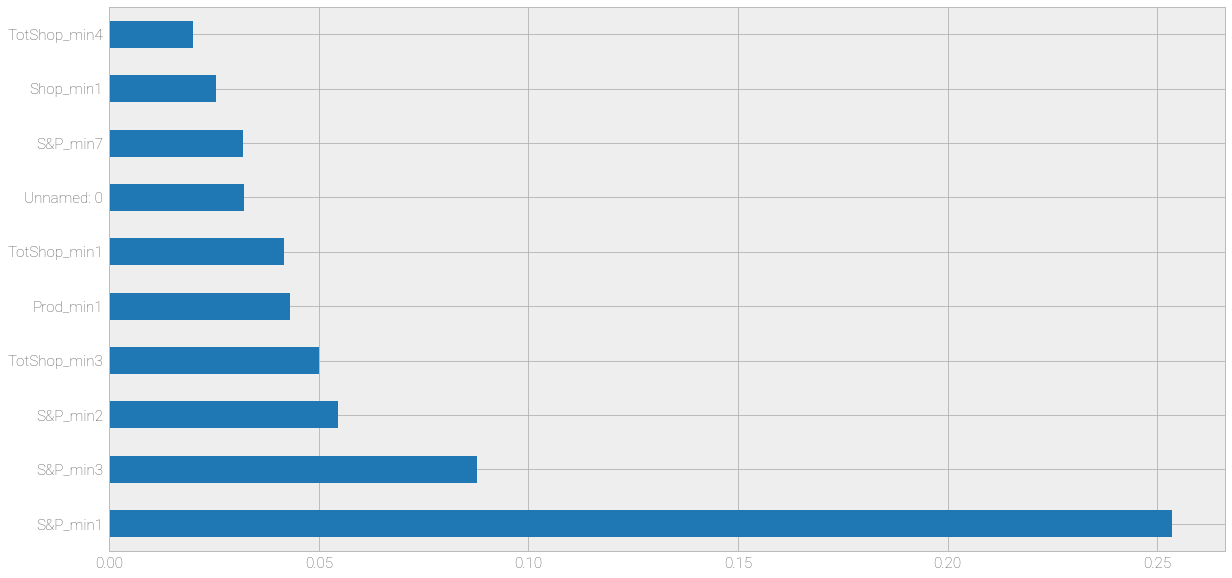

In [63]:
feat_importances = pd.Series(mod2.feature_importances_, index=NovData2_2.columns)
plt.figure(figsize=(20,10)) 
plt.rcParams.update({'font.size': 22})
feat_importances.nlargest(10).plot(kind='barh')


1002929    1002929
1002930    1002930
1002931    1002931
1002932    1002932
1002933    1002933
Name: Unnamed: 0, dtype: int64